Imports

In [28]:
import os
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

Mounting Goggle drive to collab


In [29]:
import os
import tarfile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
tar_path = '/content/drive/MyDrive/Colab Notebooks/Data/aclImdb_v1.tar.gz'
extract_to = '/content/drive/MyDrive/Colab Notebooks/rnn'

# Extract if not already extracted
if not os.path.exists(os.path.join(extract_to, 'aclImdb')):
    print("Extracting IMDB dataset to rnn/...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
    print("Extraction complete.")
else:
    print("IMDB dataset already extracted.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IMDB dataset already extracted.


Data loading

In [31]:
def load_imdb_data(data_dir, vocab_size=5000):
    def read_reviews(folder):
        texts, labels = [], []
        for label_type in ['pos', 'neg']:
            path = os.path.join(folder, label_type)
            label = 1 if label_type == 'pos' else 0
            for file in os.listdir(path):
                with open(os.path.join(path, file), encoding="utf8") as f:
                    texts.append(f.read().lower())
                    labels.append(label)
        return texts, labels

    train_texts, train_labels = read_reviews(os.path.join(data_dir, "train"))
    test_texts, test_labels = read_reviews(os.path.join(data_dir, "test"))

    def tokenize(text): return text.split()

    all_tokens = [token for text in train_texts for token in tokenize(text)]
    vocab_counts = Counter(all_tokens).most_common(vocab_size)
    vocab = {word: idx + 3 for idx, (word, _) in enumerate(vocab_counts)}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    vocab["<CLS>"] = 2

    def encode(text):
        return [vocab.get(token, vocab["<UNK>"]) for token in tokenize(text)]

    def preprocess(texts, labels):
        encoded = [[vocab["<CLS>"]] + encode(t) for t in texts]
        encoded = [torch.tensor(e[:300]) for e in encoded]  # limit to 300 tokens
        labels = torch.tensor(labels)
        return encoded, labels

    train_encoded, train_labels = preprocess(train_texts, train_labels)
    test_encoded, test_labels = preprocess(test_texts, test_labels)

    return vocab, train_encoded, train_labels, test_encoded, test_labels


loading and preprocessing the IMDB dataset

In [32]:
vocab, train_encoded, train_labels, test_encoded, test_labels = load_imdb_data(
    data_dir='/content/drive/MyDrive/Colab Notebooks/rnn/aclImdb'
)

Saving the data to load this directly

In [33]:
#saving to load this directly
save_path = '/content/drive/MyDrive/Colab Notebooks/rnn/imdb_processed.pt'

torch.save({
    'vocab': vocab,
    'train_encoded': train_encoded,
    'train_labels': train_labels,
    'test_encoded': test_encoded,
    'test_labels': test_labels
}, save_path)

print("Saved to:", save_path)


Saved to: /content/drive/MyDrive/Colab Notebooks/rnn/imdb_processed.pt


In [34]:
loaded_data = torch.load('/content/drive/MyDrive/Colab Notebooks/rnn/imdb_processed.pt')

vocab = loaded_data['vocab']
train_encoded = loaded_data['train_encoded']
train_labels = loaded_data['train_labels']
test_encoded = loaded_data['test_encoded']
test_labels = loaded_data['test_labels']



Creating the dataset and dataloaders

In [35]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class IMDBDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = pad_sequence(sequences, batch_first=True)
        self.y = labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = IMDBDataset(train_encoded, train_labels)
test_dataset = IMDBDataset(test_encoded, test_labels)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Custom RNN model

In [36]:
import torch.nn as nn

class RNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim)
        self.activation = nn.Tanh()

    def forward(self, x_t, h_prev):
        return self.activation(self.i2h(x_t) + self.h2h(h_prev))


class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_cell = RNNCell(embed_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        h = torch.zeros(x.size(0), self.hidden_dim, device=x.device)  # initial hidden state

        for t in range(embedded.size(1)):  # loop through sequence
            h = self.rnn_cell(embedded[:, t, :], h)

        return self.output_layer(h)


Initializing Loss and optimizer

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNN(vocab_size=len(vocab), embed_dim=128, hidden_dim=64, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)


Training the model

In [38]:
for epoch in range(5):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = model(batch_x)
        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 273.2660
Epoch 2: Loss = 270.0289
Epoch 3: Loss = 266.2642
Epoch 4: Loss = 260.9344
Epoch 5: Loss = 252.1554


Evaluating the model

In [39]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total
    print(f" Test Accuracy: {accuracy:.4f}")


In [40]:
evaluate(model, test_loader)


 Test Accuracy: 0.5050


testing the model on a random text|

In [41]:
def preprocess_text(text, vocab, max_len=300):
    tokens = text.lower().split()
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    encoded = [vocab["<CLS>"]] + encoded[:max_len-1]
    tensor = torch.tensor(encoded)
    return tensor


In [42]:
def predict_sentiment(text, model, vocab):
    model.eval()
    input_tensor = preprocess_text(text, vocab).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)  # shape: (1, 2)
        pred = torch.argmax(output, dim=1).item()
    return "Positive" if pred == 1 else "Negative"


In [43]:
sample_review = """
I rarely ever write reviews, but I just couldn’t help myself after watching this film. Let me just start by saying that this movie left me speechless in the best possible way. From the very beginning, the story draws you in with its stunning cinematography and hauntingly beautiful score. The performances are nothing short of extraordinary—each actor seemed to become their character with such natural conviction, I forgot I was watching a performance. The main lead delivered lines with such emotional intensity that I found myself tearing up multiple times, not because the scenes were overtly sad, but because they were so incredibly human.

What really sets this movie apart is its attention to detail. Every frame is meticulously crafted, from the lighting to the costume design to the sound mixing. You can tell that every department was in sync with the director’s vision, which is so rare these days when many films feel like they’re mass-produced for streaming platforms. Here, every moment had weight. Every pause, every glance, every note in the background added to the emotional layering of the story.

The narrative structure was also surprisingly bold. It didn’t follow a conventional linear arc, but instead wove in and out of memories, flashbacks, and dream sequences in a way that mirrored the emotional confusion of the protagonist. And yet, it was never disorienting. The editor deserves major credit for keeping the pacing tight and the transitions smooth. In fact, the nonlinear approach added a poetic depth to the story that would’ve been lost in a traditional format.

And can we talk about the soundtrack? Easily one of the best I’ve heard in years. It wasn’t just background filler—it was a character in its own right. There were moments when the music would swell in such a way that I got chills, even though nothing dramatic was happening on screen. It was like the score was speaking directly to my emotions. Whoever scored this film deserves every award there is.

There were a few supporting characters that added unexpected humor to the otherwise somber tone. But even the comic relief was tastefully done—it never felt forced or out of place. Instead, it reminded me that even in our darkest moments, there’s always a glimmer of light. That’s a hard balance to strike, but the film handled it with grace and authenticity.

The themes explored were deep and nuanced—grief, identity, forgiveness, the meaning of home, and the passage of time. But they were never spelled out. Instead, they unfolded organically through the characters' choices and interactions. I found myself thinking about my own life, my own relationships, and the things I take for granted. It’s rare to find a movie that’s not just entertaining, but also profoundly introspective.

By the time the credits rolled, I was an emotional wreck—but in the best way. I sat there for several minutes, just letting it all sink in. This movie didn’t just tell a story. It invited me to feel, to reflect, to connect. And that’s the kind of art that stays with you.

If you’re looking for a mindless blockbuster with explosions and one-liners, this isn’t it. But if you’re open to something more soulful, more artistic, more real—do yourself a favor and watch this film. It’s the kind of cinematic experience that comes around once in a blue moon. I’m so glad I gave it a chance. 10/10.
"""

print(predict_sentiment(sample_review, model, vocab))


Negative


GRU

In [44]:
import torch.nn as nn
import torch

class GRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        # Fused implementation: one linear layer for all gates from input, one from hidden
        self.x2h = nn.Linear(input_dim, 3 * hidden_dim)
        self.h2h = nn.Linear(hidden_dim, 3 * hidden_dim)

    def forward(self, x_t, h_prev):
        x_proj = self.x2h(x_t)  # (batch, 3 * hidden_dim)
        h_proj = self.h2h(h_prev)  # (batch, 3 * hidden_dim)

        x_z, x_r, x_n = x_proj.chunk(3, dim=1)
        h_z, h_r, h_n = h_proj.chunk(3, dim=1)

        z_t = torch.sigmoid(x_z + h_z)  # Update gate
        r_t = torch.sigmoid(x_r + h_r)  # Reset gate
        n_t = torch.tanh(x_n + r_t * h_n)  # Candidate activation

        h_t = (1 - z_t) * h_prev + z_t * n_t  # Final state
        return h_t


In [45]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru_cell = GRUCell(embed_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        h = torch.zeros(x.size(0), self.hidden_dim, device=x.device)

        for t in range(embedded.size(1)):
            h = self.gru_cell(embedded[:, t, :], h)

        return self.output_layer(h)


In [46]:
GRU_model = GRUModel(vocab_size=len(vocab), embed_dim=128, hidden_dim=64, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(GRU_model.parameters(), lr=0.001, weight_decay=1e-5)


In [47]:
train_losses = []
test_losses = []

for epoch in range(5):
    GRU_model.train()
    total_train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = GRU_model(batch_x)
        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on test set
    GRU_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = GRU_model(batch_x)
            loss = criterion(output, batch_y)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Test Loss = {avg_test_loss:.4f}")


Epoch 1: Train Loss = 0.6962 | Test Loss = 0.6934
Epoch 2: Train Loss = 0.6874 | Test Loss = 0.6906
Epoch 3: Train Loss = 0.5662 | Test Loss = 0.4471
Epoch 4: Train Loss = 0.3327 | Test Loss = 0.3292
Epoch 5: Train Loss = 0.2471 | Test Loss = 0.3202


loss curves

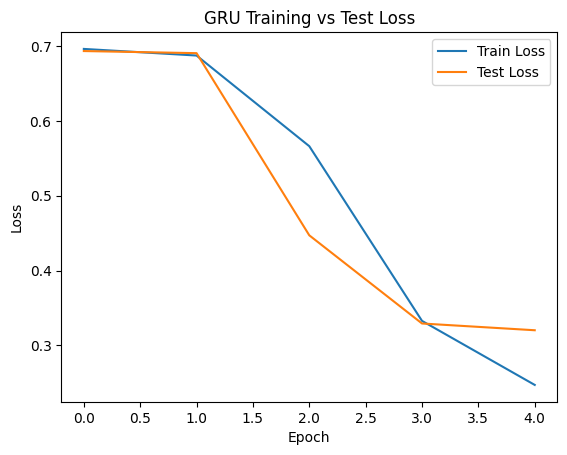

In [48]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training vs Test Loss')
plt.show()

comparing gru and rnn for test set


In [49]:
def evaluate_accuracy(GRU_model, dataloader):
    GRU_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = GRU_model(X)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [50]:
print("Evaluating RNN:")
evaluate(model, test_loader)

print("Evaluating GRU:")
evaluate(GRU_model, test_loader)



Evaluating RNN:
 Test Accuracy: 0.5050
Evaluating GRU:
 Test Accuracy: 0.8645


# Observations

In this project, we built custom implementations of both a basic RNN and a GRU to perform sentiment classification on the IMDB movie reviews dataset. We used embeddings to represent the input text and manually unrolled the sequences over time to compute hidden states. The final hidden state from each sequence was used to predict whether a review was positive or negative. For training, we used the AdamW optimizer and evaluated both models based on their accuracy on the training and test sets.

The GRU model clearly outperformed the basic RNN. While the RNN achieved accuracyof 50% in test data, it struggled to capture long-range dependencies in the text, resulting in lower performance on both training and test data. In contrast, the GRU reached around 86% test accuracy, demonstrating its strength in modeling sequential data more effectively.

PyTorch Official Documentation:  (https://pytorch.org/docs/stable/index.html)

- PyTorch Tutorials:
  - [Text Classification with an RNN](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)
